# Illustrations of the workflow of our method

Scroll to the end of the notebook to run our method with some illustrations shown for each major step of the algorithm. You can run the method with various parameters to see their effect on various parts of the method.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math
import scipy.stats as st
import matplotlib.cm as cm

In [2]:
from data_processing import load_eth
eth_data = load_eth()
agent_ids = pd.unique(eth_data.agent_id)

## Helper methods

In [3]:
def agent_data(data, agent_id):
    x = data["pos_x"].loc[data["agent_id"]==agent_id].values
    y = data["pos_y"].loc[data["agent_id"]==agent_id].values
    
    return x, y

# Sample train and test data for pos_x and pos_y, each slice with num_steps length
def get_agent_train_test(data, agent_id, num_steps=5):
    sample_x = data["pos_x"].loc[data["agent_id"]==agent_id][:num_steps].values
    sample_y = data["pos_y"].loc[data["agent_id"]==agent_id][:num_steps].values

    test_x = data["pos_x"].loc[data["agent_id"]==agent_id][num_steps:num_steps+2*num_steps].values
    test_y = data["pos_y"].loc[data["agent_id"]==agent_id][num_steps:num_steps+2*num_steps].values
    
    return sample_x, sample_y, test_x, test_y
    
def calculate_FDE(pred_x, pred_y, test_x, test_y):

    final_displacement_x = pred_x[-1] - test_x[-1]
    final_displacement_y = pred_y[-1] - test_y[-1]
    FDE = np.sqrt(final_displacement_x**2 + final_displacement_y**2)
    
    return FDE

### Plotting

In [4]:
def plot_KDE(x_data, y_data, xx, yy, f):
    plt.figure(figsize=(10, 10))
    plt.axes().set_aspect('equal')
    plt.grid(alpha=0.5)
    
    CS = plt.contour(xx, yy, f, levels=[0.005, 0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56])
    plt.clabel(CS, inline=1, fontsize=10)
    
    plt.plot(x_data, y_data, c='b')
    plt.scatter(x_data, y_data, c='b')

    plt.title("Kernel density estimation on the final points of the generated trajectories")
    plt.show()
        
def plot_all_trajectories_with_only_train(sample_x, sample_y, pred_xs, pred_ys, finalize_plot = True):
    plt.figure(figsize=(10, 10))
    plt.axes().set_aspect('equal')
    plt.grid(alpha=0.5)
    
    plt.plot(sample_x, sample_y, c='b', label='seen trajectory')
    plt.scatter(sample_x, sample_y, c='b')
    
    for i in range(len(pred_xs)):
        plt.plot(pred_xs[i], pred_ys[i], linewidth=0.25)
    
    if finalize_plot:
        plt.legend()
        plt.show()

## Model
Implementation of our model. Overall it is the same as in 'generative_model.py', but with some plotting added to different steps.

In [5]:
import numpy as np
import math
import scipy.stats as st
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids

# Decide whether to use the constant velocity model or constant turning model for generating future trajectories
def get_model(params):
    if np.random.rand() < params['CONST_VEL_MODEL_PROB']:
        return 'CONST_VEL'
    else:
        return 'CONST_VEL_W_ROTATION'

# Get a random action to apply during the CVM prediction
def get_action(params):
    if np.random.rand() < params['STOP_PROB']:
        return 'STOP'
    if np.random.rand() < params['VELOCITY_CHANGE_PROB']:
        return 'VELOCITY_CHANGE'
    if np.random.rand() < params['ANGLE_CHANGE_PROB']:
        return 'ANGLE_CHANGE'
    return None

# Calculate the base constant velocity for CVM predictions
def get_const_vel(params, sample_vel_x, sample_vel_y):
    if np.random.rand() < params['DISCOUNT_AVG_PROB']:
        discount = np.random.uniform(low=params['DISCOUNT_LOWER_BOUND'])
        # for [1,2,3] with discount of 0.5, the weights would be 0.5**2, 0.5**1, 0.5**0
        const_vel_x = np.average(sample_vel_x, weights=[discount ** i for i in np.arange(len(sample_vel_x)-1, -1, -1)])
        const_vel_y = np.average(sample_vel_y, weights=[discount ** i for i in np.arange(len(sample_vel_x)-1, -1, -1)])
    else:
        const_vel_x = np.mean(sample_vel_x)
        const_vel_y = np.mean(sample_vel_y)
        
    return const_vel_x, const_vel_y

# Calculate the base constant velocity for the constant turning model predictions
def get_angle(params, sample_vel_x, sample_vel_y):
    all_angles = []
    for i in range(1, len(sample_vel_x)):
        prev_vel = [sample_vel_x[i-1], sample_vel_y[i-1]]
        curr_vel = [sample_vel_x[i], sample_vel_y[i]]
        one_angle = np.math.atan2(np.linalg.det([prev_vel, curr_vel]),np.dot(prev_vel, curr_vel))   
        all_angles.append(one_angle)
    
    if np.random.rand() < params['DISCOUNT_AVG_PROB']:
        discount = np.random.uniform(low=params['DISCOUNT_LOWER_BOUND'])
        angle = np.average(all_angles, weights=[discount ** i for i in np.arange(len(all_angles)-1, -1, -1)])
    else:
        angle = np.mean(all_angles)
    return angle

# Calculate final displacement error
def calculate_FDE(pred_x, pred_y, test_x, test_y):
    final_displacement_x = pred_x[-1] - test_x[-1]
    final_displacement_y = pred_y[-1] - test_y[-1]
    FDE = np.sqrt(final_displacement_x**2 + final_displacement_y**2)
    
    return FDE

#Rotate a point counterclockwise by a given angle around a given origin.
#The angle should be given in radians.
def rotate(origin, point, angle):
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

# Generates one future trajectory for a historical path
def generate_trajectory(sample_x, sample_y, params, length=5):
    # Add noise to the historical trajectory
    sample_vel_x = [(sample_x[i] - sample_x[i-1]) + np.random.normal(0, params['NOISE']) for i in range(1, len(sample_x))]
    sample_vel_y = [(sample_y[i] - sample_y[i-1]) + np.random.normal(0, params['NOISE']) for i in range(1, len(sample_y))]
    
    # Calculate the constant velocity and constant angle
    const_vel_x, const_vel_y = get_const_vel(params, sample_vel_x, sample_vel_y)
    angle = get_angle(params, sample_vel_x, sample_vel_y)

    # Start predicting
    pred_x = []
    pred_y = []
    model = get_model(params)
    for _ in range(length):
        action = get_action(params)
        if action == 'STOP':
            # For the stop event, the next predicted point will be exactly the same as the last point
            if len(pred_x) == 0:
                pred_x.append(sample_x[-1])
                pred_y.append(sample_y[-1])
            else:
                pred_x.append(pred_x[-1])
                pred_y.append(pred_y[-1])
            continue
            
        elif action == 'VELOCITY_CHANGE':
            const_vel_x = const_vel_x + np.random.normal(0, params['VELOCITY_CHANGE_NOISE'])
            const_vel_y = const_vel_y + np.random.normal(0, params['VELOCITY_CHANGE_NOISE'])
        elif action == 'ANGLE_CHANGE':
            angle = angle + np.random.normal(0, params['ANGLE_CHANGE_NOISE'])
        
        if model == 'CONST_VEL':
            if len(pred_x) == 0:
                pred_x.append(sample_x[-1] + const_vel_x)
                pred_y.append(sample_y[-1] + const_vel_y)
            else:
                pred_x.append(pred_x[-1] + const_vel_x)
                pred_y.append(pred_y[-1] + const_vel_y)
        elif model == 'CONST_VEL_W_ROTATION':
            if len(pred_x) == 0:
                prev_x = sample_x[-2]
                prev_y = sample_y[-2]
                cur_x = sample_x[-1] + const_vel_x
                cur_y = sample_y[-1] + const_vel_y
            else:
                prev_x = pred_x[-1]
                prev_y = pred_y[-1]
                cur_x = pred_x[-1] + const_vel_x
                cur_y = pred_y[-1] + const_vel_y
            rot_x, rot_y = rotate((prev_x, prev_y), (cur_x, cur_y), angle)
            pred_x.append(rot_x)
            pred_y.append(rot_y)
            
            # Redefine the average velocity as it now has a new heading
            const_vel_x = rot_x - prev_x
            const_vel_y = rot_y - prev_y
        
    return pred_x, pred_y

# Run k-means clustering on many future trajectory predictions
def run_clustering(pred_x_list, pred_y_list, no_of_clusters, clustering_method='KMeans'):
    final_points = []
    for i in range(len(pred_x_list)):
        final_points.append([pred_x_list[i][-1], pred_y_list[i][-1]])
    
    if clustering_method == 'KMeans':
        clustering = KMeans(n_clusters=no_of_clusters)
    elif clustering_method == 'KMedoids':
        clustering = KMedoids(n_clusters=no_of_clusters)
    else:
        raise Exception("Unsupported clustering method: ", clustering_method)
    clustering.fit(final_points)

    cluster_avg_x, cluster_avg_y, no_of_elements_per_cluster = get_clustered_averages(pred_x_list, pred_y_list, no_of_clusters, clustering.labels_)

    return cluster_avg_x, cluster_avg_y, no_of_elements_per_cluster

# Get the average trajectory of each cluster attained from K-means clustering
def get_clustered_averages(all_pred_x, all_pred_y, no_of_clusters, cluster_labels):
    no_of_elements_per_cluster = []
    for i in range(no_of_clusters):
        no_of_elements_per_cluster.append((cluster_labels == i).sum())
    
    clustered_preds_x = [[] for _ in range(no_of_clusters)]
    clustered_preds_y = [[] for _ in range(no_of_clusters)]

    for idx, cluster_label in enumerate(cluster_labels):
        clustered_preds_x[cluster_label].append(all_pred_x[idx])
        clustered_preds_y[cluster_label].append(all_pred_y[idx])
        
    cluster_avg_x = [[] for _ in range(no_of_clusters)]
    cluster_avg_y = [[] for _ in range(no_of_clusters)]
    
    for i in range(no_of_clusters):
        cluster_avg_x[i] = np.mean(clustered_preds_x[i], axis=0)
        cluster_avg_y[i] = np.mean(clustered_preds_y[i], axis=0)
        
    return cluster_avg_x, cluster_avg_y, no_of_elements_per_cluster

# Smoothen an array of coordinates of one axis
def smoothen(list_of_coordinates):
    copy = list_of_coordinates.copy()
    for coordinates in copy:
        for i in range(1, len(coordinates)-1):
            # replace each coordinate with the average of two surrounding coordinates
            coordinates[i] = (coordinates[i-1] + coordinates[i+1]) / 2
    return copy

def predict(sample_x, sample_y, params, trajectory_length=5, clustering_method='KMeans', smoothing=True):
    all_pred_x, all_pred_y = [], []
    all_final_x, all_final_y = [], []
    
    for _ in range(params['NO_OF_TRAJECTORIES']):
        pred_x, pred_y = generate_trajectory(sample_x, sample_y, params, trajectory_length)
        all_pred_x.append(pred_x)
        all_pred_y.append(pred_y)
        
        all_final_x.append(pred_x[-1])
        all_final_y.append(pred_y[-1])
        
    plot_all_trajectories_with_only_train(sample_x, sample_y, all_pred_x, all_pred_y, finalize_plot=False)
    plt.title("All generated future trajectories")
    plt.show()
    
    # Run kernel density estimation
    values = np.vstack([all_final_x, all_final_y])
    kernel = st.gaussian_kde(values)
    
    # plot the KDE
    kernel_density_estimation(sample_x, sample_y, all_final_x, all_final_y)
    
    # Evaluate trajectories
    evaluated = kernel.evaluate(values)
    # Find the sorting order for the trajectories based on KDE pdf
    sorting_order = evaluated.argsort()[::-1] # Note: the sorting order is ascending by default, [::-1] reverses the order (might be too slow though?)
    
    # Sort predictions by KDE density
    sorted_all_pred_x = np.array(all_pred_x)[sorting_order]
    sorted_all_pred_y = np.array(all_pred_y)[sorting_order]
    
    no_of_traj = len(sorted_all_pred_x)

    # The first group has a slightly different behaviour than the rest. We don't want to just take the top [first_group_size] % of
    # the generated trajectories by KDE, but we want to take the top [first_group_size] % of the trajectories closest to our 'best'
    # trajectory (the one with the highest estimated density). We can think of the first group as the group surrounding the densest area.

    # To achieve this, we take the trajectory with the highest density estimation and calculate every other trajectory's distance
    # from it. Based on the distances, we move the ones with the lowest distance to the front of the sorted generated trajectories.
    highest_density_x = sorted_all_pred_x[0]
    highest_density_y = sorted_all_pred_y[0]
    largest_distance = None
    closest_indexes = np.array([], dtype=np.int8)
    closest_distances = np.array([])
    
    TOP_GROUP_MAX_SIZE = no_of_traj*params['GROUP_PERCENTAGES'][0]
    for idx in range(len(sorted_all_pred_x)):
        distance = calculate_FDE(highest_density_x, highest_density_y, sorted_all_pred_x[idx], sorted_all_pred_y[idx])
        
        # Firstly, we fill the closest_indexes array with as many instances as we allow in the first group
        if len(closest_indexes) < TOP_GROUP_MAX_SIZE:
            closest_indexes = np.append(closest_indexes, idx)
            closest_distances = np.append(closest_distances, distance)
            if largest_distance == None or largest_distance < distance:
                largest_distance = distance
        # Now the closest_indexes is initially 'full'. If the current instance is closer than the furthest one
        # in the closest_indexes as of now, then we replace it.
        else:
            if largest_distance > distance:
                index_max = np.argmax(closest_distances)
                closest_indexes[index_max] = idx
                closest_distances[index_max] = distance
                largest_distance = np.amax(closest_distances)
    
    # Get the closest trajectories
    closest_x = sorted_all_pred_x[closest_indexes]
    closest_y = sorted_all_pred_y[closest_indexes]

    # Remove the closest trajectories from the data...
    sorted_all_pred_x = np.delete(sorted_all_pred_x, closest_indexes, axis=0)
    sorted_all_pred_y = np.delete(sorted_all_pred_y, closest_indexes, axis=0)
    
    # ...and move them to the front of the array
    sorted_all_pred_x = np.append(closest_x, sorted_all_pred_x, axis=0)
    sorted_all_pred_y = np.append(closest_y, sorted_all_pred_y, axis=0)
    
    # Return values will be in a format of [pred_xs: list, pred_ys: list, pred_weigths: list]
    return_values = [[], [], []]

    ## Loop over the representative groups and run K-means clustering on each
    ## (if the group should return more than 1 representative trajectory)
    
    # Plotting the clusters/final predictions
    plot_all_trajectories_with_only_train(sample_x, sample_y, [], [], finalize_plot=False)
    plt.title("Chosen representative predictions")
    colors = cm.rainbow(np.linspace(0, 1, len(params['GROUP_CLUSTER_COUNT'])))

    prev_group_size_end = 0
    group_size_ends = params['GROUP_PERCENTAGES']
    for group_idx, group_size_end in enumerate(group_size_ends):
        group_cluster_count = params['GROUP_CLUSTER_COUNT'][group_idx]
        
        # Get the current group of generated trajectories
        group_x = sorted_all_pred_x[int(no_of_traj*prev_group_size_end):int(no_of_traj*group_size_end)]
        group_y = sorted_all_pred_y[int(no_of_traj*prev_group_size_end):int(no_of_traj*group_size_end)]
        
        # No need to run k-means clustering if the group is supposed to have just 1 representative cluster
        if group_cluster_count == 1:
            representative_x = np.mean(group_x, axis=0)
            representative_y = np.mean(group_y, axis=0)
            if smoothing:
                representative_x = smoothen(np.array([representative_x]))[0] # create an array to fit the smoothen() function (could add a case there for handling a single trajectory)
                representative_y = smoothen(np.array([representative_y]))[0]
            
            trajectory_weight = len(representative_x)/no_of_traj
            
            plt.plot(representative_x, representative_y, c='green', linewidth=3)
            plt.annotate(trajectory_weight, (representative_x[-1], representative_y[-1]))
            
            return_values[0].append(representative_x)
            return_values[1].append(representative_y)
            return_values[2].append(trajectory_weight)
        else:
            group_data = run_clustering(group_x, group_y, no_of_clusters=group_cluster_count, clustering_method=clustering_method)
            group_pred_xs, group_pred_ys, group_no_of_trajs = group_data
            
            if smoothing:
                group_pred_xs = smoothen(group_pred_xs)
                group_pred_ys = smoothen(group_pred_ys)
                
            for i in range(len(group_pred_xs)):
                plt.plot(group_pred_xs[i], group_pred_ys[i], c=colors[group_idx], linewidth=1.5)
                plt.annotate(group_no_of_trajs[i]/no_of_traj, (group_pred_xs[i][-1], group_pred_ys[i][-1]))
            
            return_values[0] = return_values[0] + [*group_pred_xs]
            return_values[1] = return_values[1] + [*group_pred_ys]
            return_values[2] = return_values[2] + [*[i/no_of_traj for i in group_no_of_trajs]]
        
        prev_group_size_end = group_size_end
   
    # Return [all_x_predictions, all_y_predictions, all_weights]
    return return_values


In [6]:
# For plotting purposes only
def kernel_density_estimation(x_data, y_data, all_final_x, all_final_y):
    all_final_x = np.array(all_final_x)
    all_final_y = np.array(all_final_y)
    
    xmin, xmax = min(all_final_x), max(all_final_x)
    ymin, ymax = min(all_final_y), max(all_final_y)
    
    xdiff = xmax - xmin
    ydiff = ymax - ymin
    
    xmin = xmin - 0.5*xdiff
    xmax = xmax + 0.5*xdiff
    
    ymin = ymin - 0.5*ydiff
    ymax = ymax + 0.5*ydiff
    
    # Peform the kernel density estimate
    xx, yy = np.mgrid[xmin:xmax:300j, ymin:ymax:300j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([all_final_x, all_final_y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    plot_KDE(x_data, y_data, xx, yy, f)



## Illustrations

For each agent's historical trajectory, plot
1. All generated future trajectories
2. KDE plot of the generated trajectories
3. Representative predictions (each color represents a separate cluster)

Agent id:  2.0


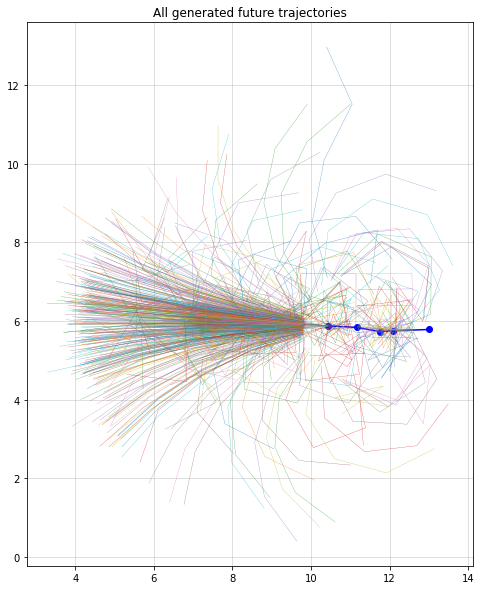

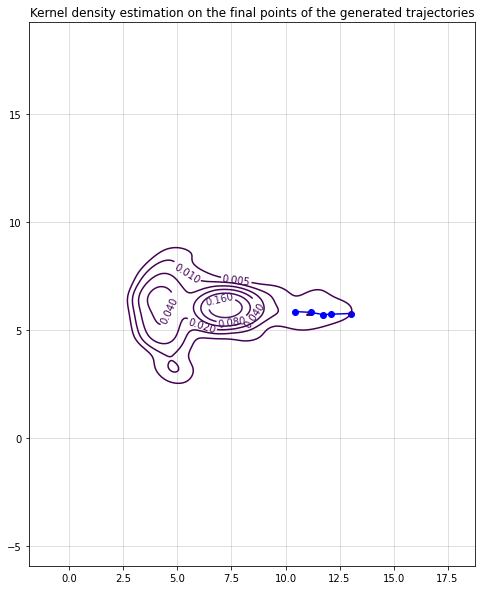

Agent id:  3.0


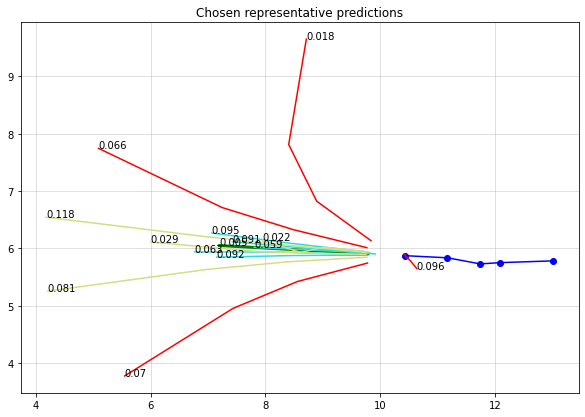

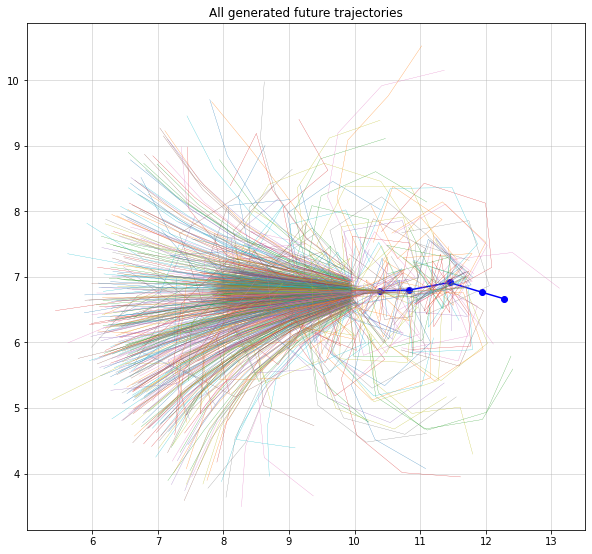

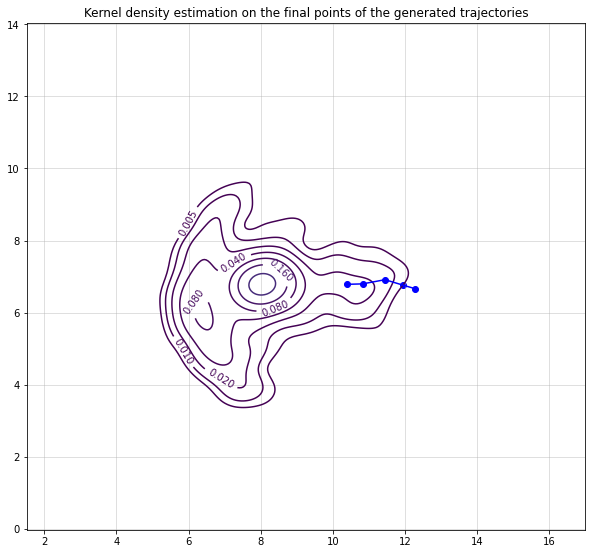

Agent id:  5.0


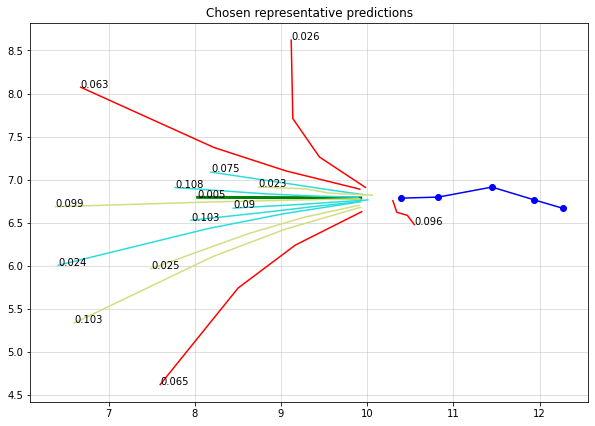

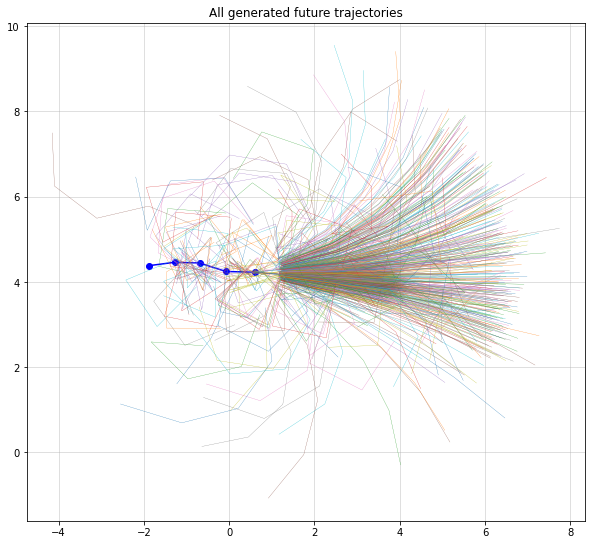

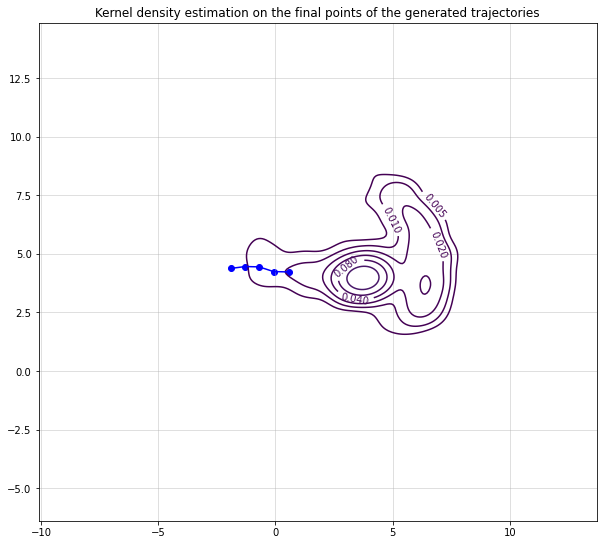

Agent id:  4.0


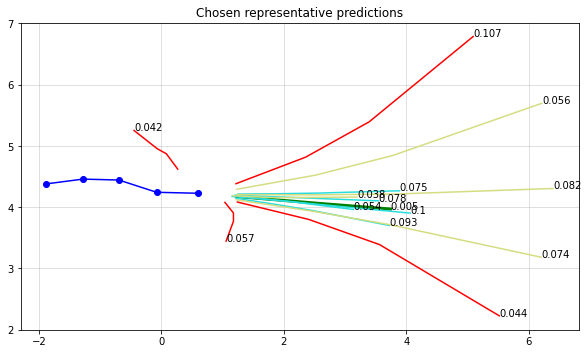

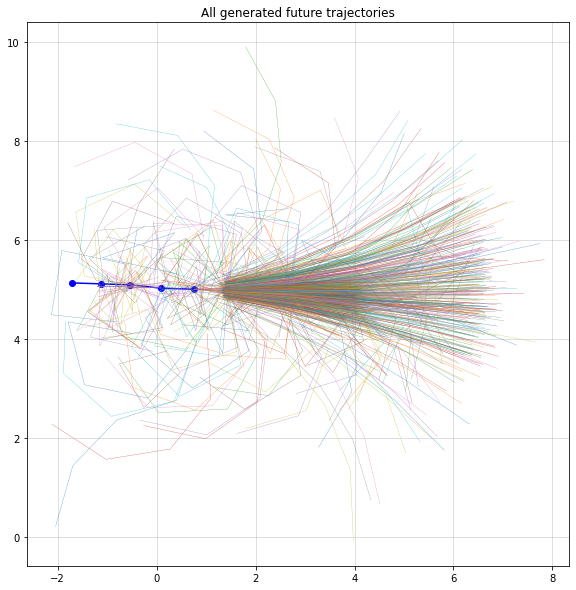

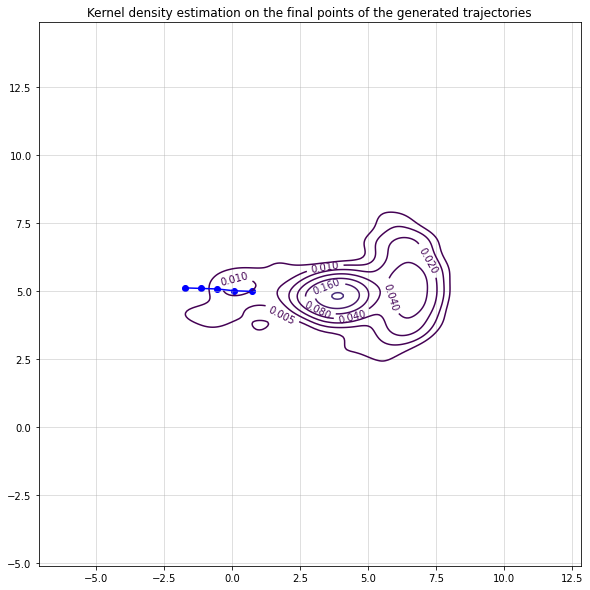

Agent id:  6.0


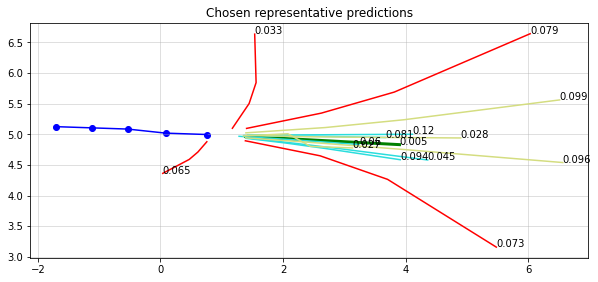

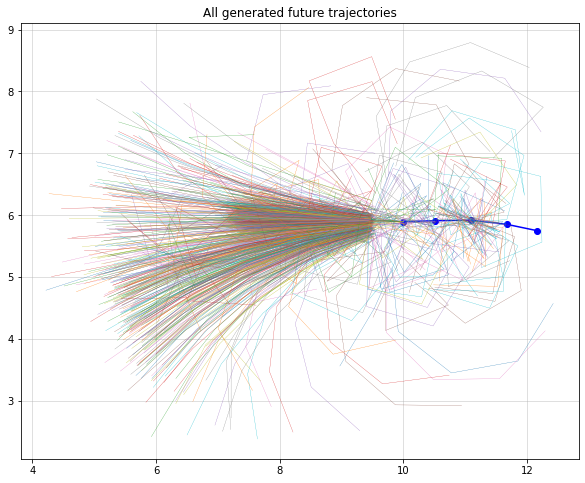

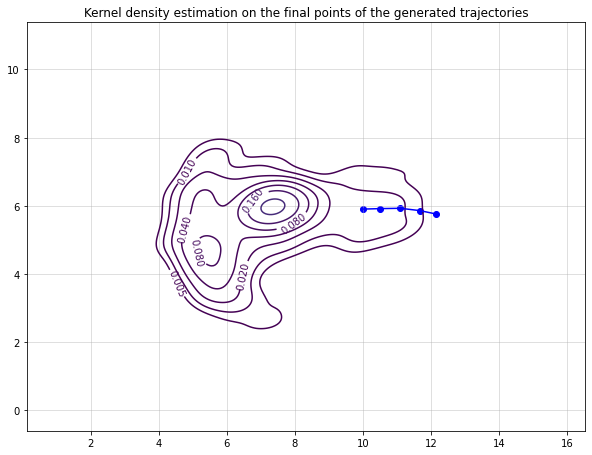

Agent id:  7.0


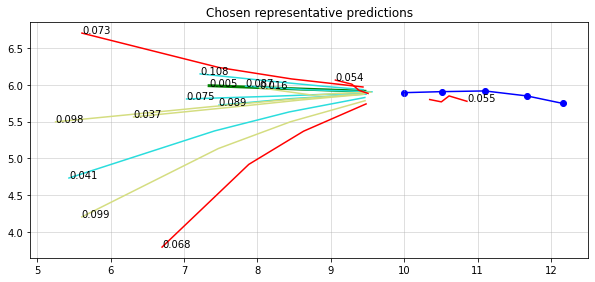

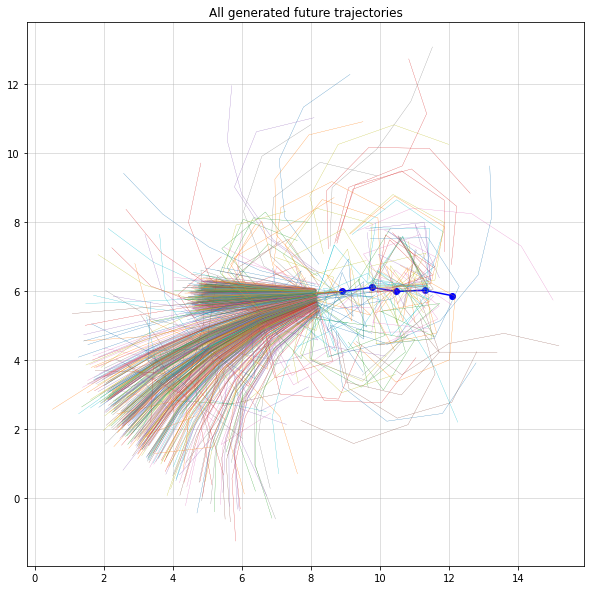

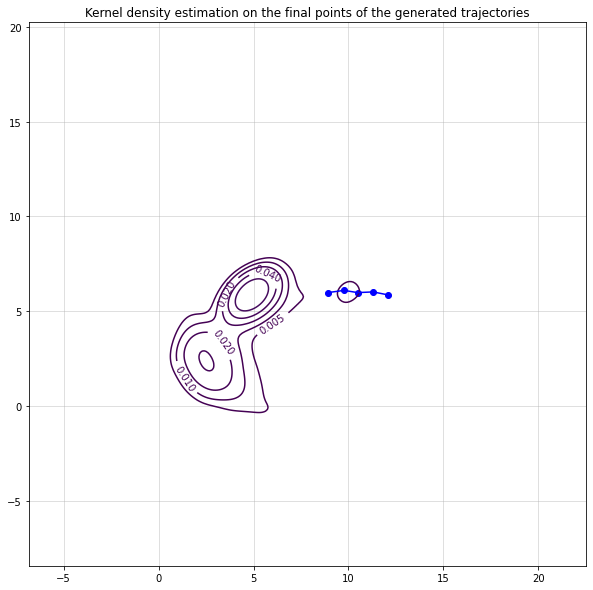

Agent id:  8.0


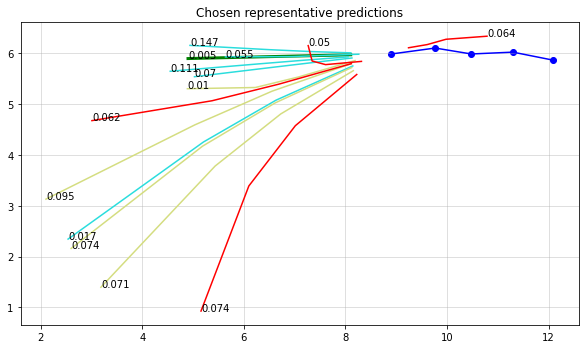

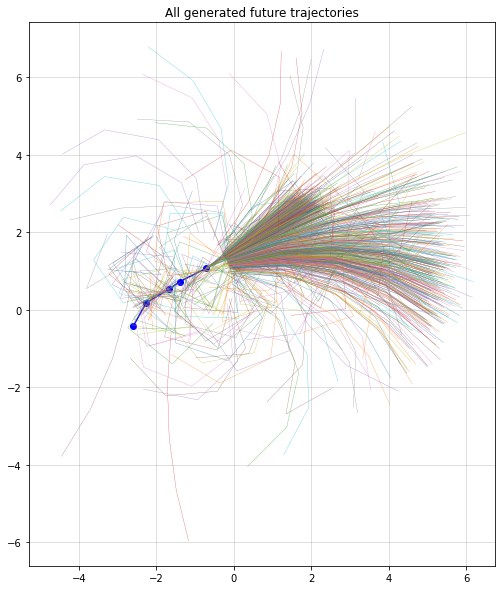

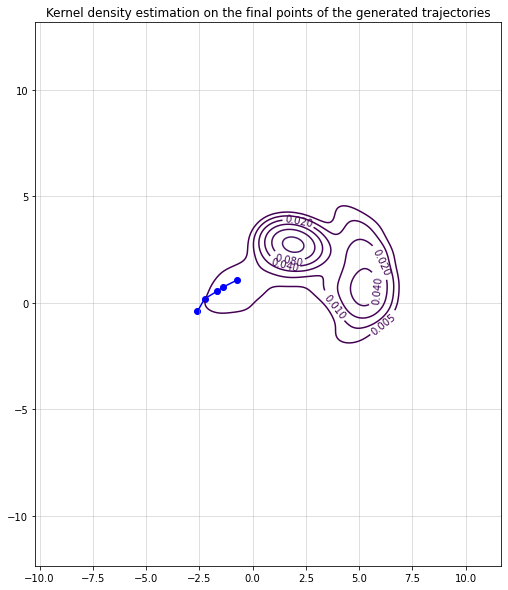

Agent id:  9.0


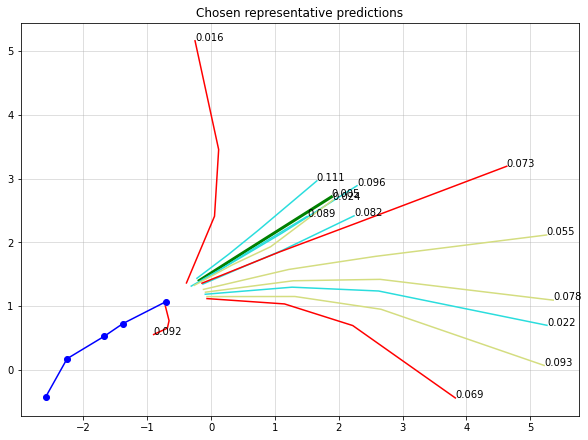

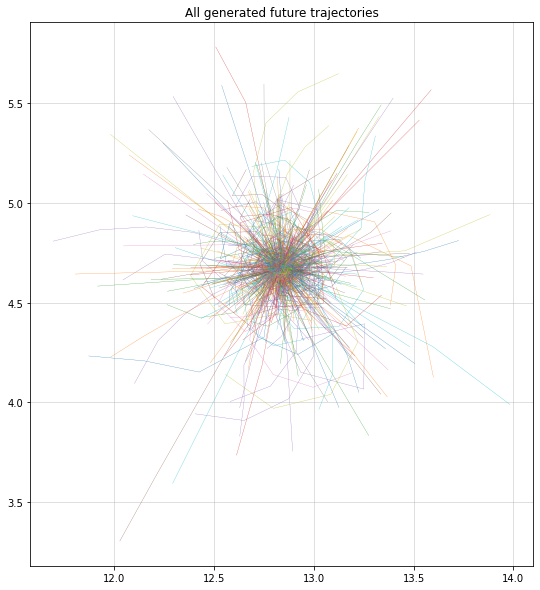

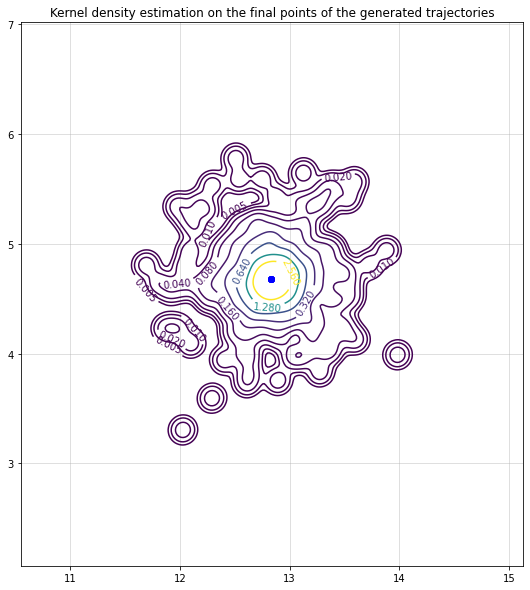

Agent id:  10.0


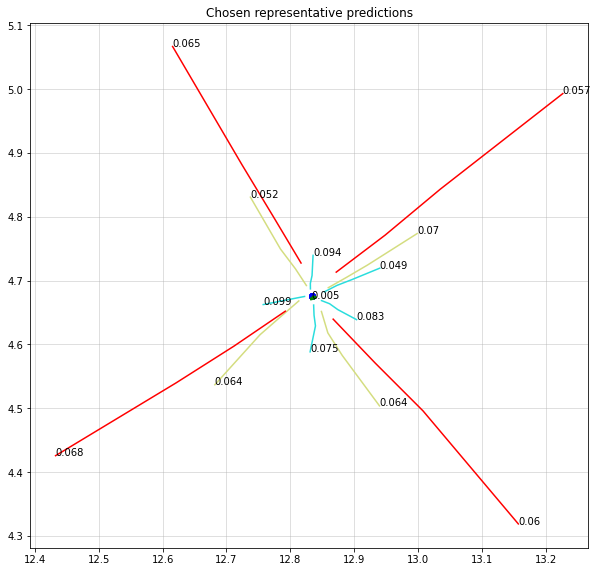

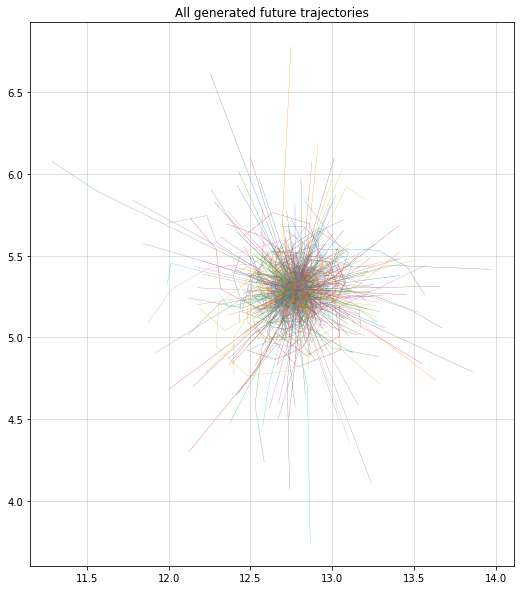

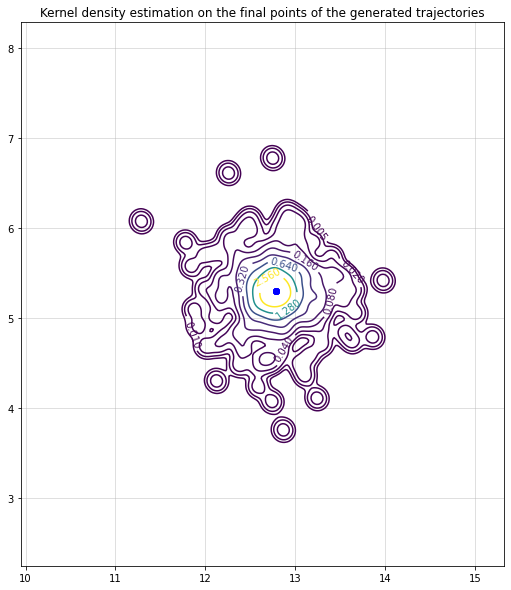

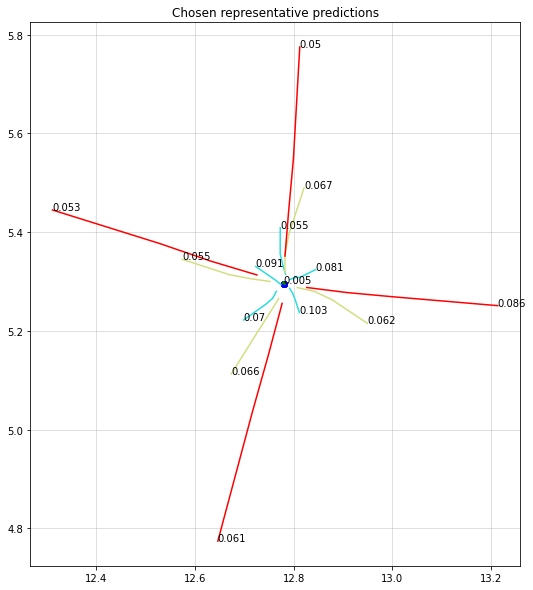

In [8]:
# Change the values of the parameters to change the behaviour of the method
params = {
    'NOISE': 0.05, 
    'NO_OF_TRAJECTORIES': 1000, 
    'CONST_VEL_MODEL_PROB': 0.5, 
    'STOP_PROB': 0.025, 
    'DISCOUNT_AVG_PROB': 1.0, 
    'DISCOUNT_LOWER_BOUND': 0.15, 
    'VELOCITY_CHANGE_PROB': 0.1,
    'VELOCITY_CHANGE_NOISE': 0.1, 
    'ANGLE_CHANGE_PROB': 0.1, 
    'ANGLE_CHANGE_NOISE': 2, 
    'GROUP_PERCENTAGES': [0.1, 0.5, 0.75, 1.0], 
    'GROUP_CLUSTER_COUNT': [1, 5, 4, 4]
}

# Change this to change the history and prediction length in timesteps
traj_length = 5

# Change the bounds in agent_ids[low:high] to see different sections of the dataset
for agent_id in agent_ids[:10]:
    
    sample_x, sample_y, test_x, test_y = get_agent_train_test(eth_data, agent_id, traj_length)
    
    if len(sample_x) >= traj_length and len(test_x) >= traj_length:
        print("Agent id: ", agent_id)
        predict(sample_x, sample_y, params)
        print("========================================================")